# Distributed Training with TPU Strategy

## Load Libraries

In [37]:
import tensorflow as tf
import numpy as np
import os
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

In [43]:
tf.compat.v1.disable_eager_execution()

In [2]:
print(tf.__version__)

2.4.1


## Connect to TPU Cluster

In [44]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

ValueError: ignored

In [45]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 8


## Load Dataset

In [46]:
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

In [47]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [48]:
# You can also do info.splits.total_num_examples to get the total
# number of examples in the dataset.

num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [49]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255

  return image, label

In [50]:
train_dataset = mnist_train.map(scale).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scale).batch(BATCH_SIZE)

In [51]:
with strategy.scope():
  tpu_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])

  tpu_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

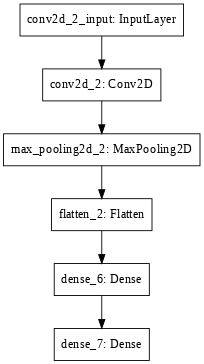

In [52]:
plot_model(tpu_model,dpi=64)

In [53]:
# Define the checkpoint directory to store the checkpoints

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [54]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    #tf.keras.callbacks.LearningRateScheduler(decay),
    #PrintLR()
]

In [55]:
%%time
history = tpu_model.fit(train_dataset, epochs=12, callbacks=callbacks)

Instructions for updating:
Use the iterator's `initializer` property instead.


Instructions for updating:
Use the iterator's `initializer` property instead.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:492: UserWarning: `tf.keras.backend.learning_phase_scope` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.learning_phase_scope` is deprecated and '


Epoch 1/12


UnimplementedError: ignored